In [48]:
# Purpose is to change the global coupling (gain) and change the thalamoconnectivity 
# First try changing the gain and compare the FC and SC and plot it as a function of global variability

%pylab nbagg
from tvb.simulator.lab import *
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
import numpy as np
import matplotlib.pyplot as plt
import tvb.analyzers.correlation_coefficient as corr_coeff
from tvb.datatypes.time_series import TimeSeriesRegion
import time

# to get an estimate of simulation time use: tic=time.time()
#tic-time.time() 
# Bezgin 2017 Human Brain Mapping for information on the 96 parcellation

Populating the interactive namespace from numpy and matplotlib


In [49]:
def run_sim(conn, gain, D, dt=0.5, simlen=1e3):
    """
    Run a single instance of the simulation.
    Returns a list of pairs (times, values). There will be one entry
    in the list for each output monitor used.
    """
    mon_raw = monitors.Raw()
    mon_tavg = monitors.TemporalAverage(period=5.0)#period=2**-2)

    #Bundle them
    what_to_watch = (mon_tavg, mon_raw)
    
    
    sim = simulator.Simulator(
        
        model=models.Generic2dOscillator(a=0.0),
        # Change the Conn matrix here; make it twice as large three times as large
        connectivity=conn,  # use the connectivity structure defined below
        #coupling=coupling.PreSigmoidal(H=gain,theta=0.0,dynamic=False), # parameters?
        coupling=coupling.Linear(a=gain),
        integrator=integrators.HeunStochastic(dt=dt,
                           noise=noise.Additive(nsig=np.array([D]))),
        monitors = what_to_watch
    )
    sim.configure()
    
    #Perform the simulation
    res = sim.run(simulation_length=simlen)
    (tavg_time,tavg_dat),(raw_time,raw_dat) = res
    
    return sim,tavg_time,tavg_dat,raw_time,raw_dat


In [62]:
# set the connectivity structure and manipulate it
conn=connectivity.Connectivity.from_file('connectivity_96.zip')

# check which connections are thalamic 
#[i_it for i_it,i in enumerate(conn96.region_labels) if 'TM-' in i] [41, 42, 43, 89, 90, 91]

# remove nodes and see what happens

#conn.weights[[41, 42, 43, 89, 90, 91],:] = 0.
#conn.weights[:, [41, 42, 43, 89, 90, 91]] = 0.

conn.configure()
#conn.weights[[41, 42, 43, 89, 90, 91],:]

data_struct=conn.weights;
import scipy.io as sio
sio.savemat('/Users/RChenLab/Documents/TVB_Distribution/demo_scripts/Github/ThalCorProject/data_struct.mat',{'data_struct':data_struct})
conn.weights.shape
conn.weights[[41, 42, 43, 89, 90, 91],:]

WARNING  File 'hemispheres' not found in ZIP.


array([[ 0.,  0.,  0.,  3.,  2.,  0.,  2.,  2.,  0.,  0.,  2.,  3.,  2.,
         2.,  1.,  2.,  2.,  3.,  3.,  1.,  2.,  3.,  2.,  3.,  3.,  3.,
         2.,  3.,  3.,  3.,  0.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 3.,  3.,  1.,  1.,  3.,  0.,  2.,  2.,  0.,  0.,  2.,  3.,  2.,
         3.,  3.,  3.,  3.,  3.,  3.,  0.,  2.,  2.,  2.,  2.,  3.,  2.,
         2.,  2.,  2.,  2.,  2.,  3.,  3.,  2.,  3.,  3.,  3.,  2.,  3.,
         2.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,

In [51]:
# Run the simulation

# using the gain parameter specified on the command line,
# run one instance of the simulation
# the label is there simply to allow running multiple of these in parallel
# without clobbering each other's output files
burnin=500
d = {}
g=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1]
raw_show={}
tic=time.time()
for i in range(len(g)):
    sim,tavg_time,tavg_dat,raw_time,raw_dat = run_sim(conn, g[i], 5e-4, simlen=1e3)
    # reshape the data which are output with some empty dimensions
    raw_timep=raw_time[burnin:,]
    raw = raw_dat
    # calculate global variance
    raw = raw[:,0,:,0]
    simdata=raw[burnin:,:] # remove the burnin period
    g[i]=round(g[i],2)
    VAR=np.var(simdata)
    d[g[i]] = VAR
    raw_show[g[i]]=raw_dat[burnin:,:,:,:]
'simulation required %0.3f seconds.' % (time.time() - tic, )
print(d)
print(simdata.shape)

{0.0: 0.032085643042661163, 0.5: 8.1759219063044331, 0.2: 3.5875250035288229, 0.4: 6.9891112184880768, 1.0: 7.3608655690987117, 0.8: 7.2596691353098697, 0.6: 7.9767060521300168, 0.3: 5.3555787482995134, 0.1: 1.625245388014416}
(1500, 96)


<IPython.core.display.Javascript object>


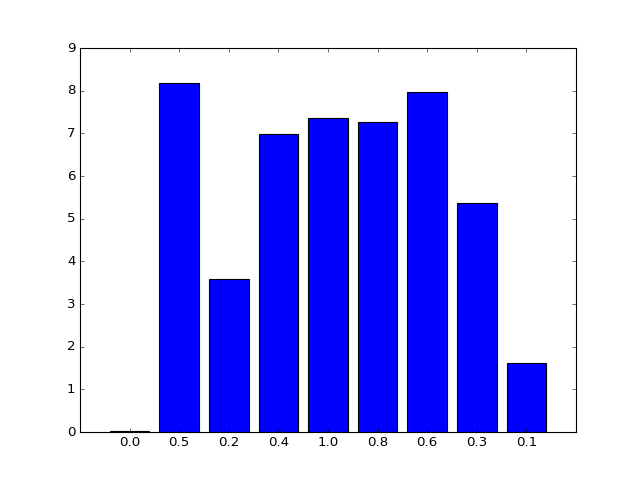

In [52]:
# now plot as a function of gain
figure()
plt.bar(range(len(g)), d.values(), align='center')
plt.xticks(range(len(d)), d.keys())
show()

<IPython.core.display.Javascript object>


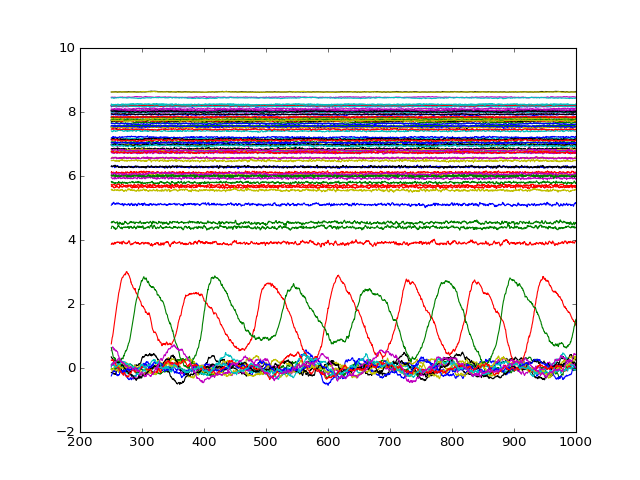

In [53]:
# choose data for which coupling you want to visualize (show time series) and compute correlation coefficient
RAW=raw_show[0.4]
figure()
plot(raw_timep, RAW[:,0,:,0])
show()

In [58]:
def compare_con(gain,RAW):
    data_show=RAW[gain]
    # compute functional connectivity using analyzer
    tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                           data=data_show,
                           sample_period=sim.monitors[0].period)
    tsr.configure()
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    # plot
    figure(figsize=(10, 4))
    subplot(121), imshow(conn.weights, cmap='binary', interpolation='none')
    subplot(122), imshow(FC, cmap='binary', interpolation='none');
    plt.colorbar()
    show()
    return data_show

   INFO  result shape will be: (96, 96, 1, 1)


<IPython.core.display.Javascript object>


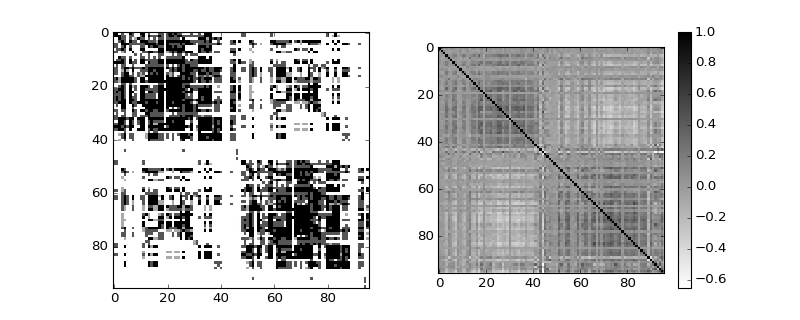

In [59]:
data_show=compare_con(0.4,raw_show)
data_show.shape

data_reshaped=data_show[:,0,:,0]


In [44]:
data_reshaped.shape

(1500, 96)

<IPython.core.display.Javascript object>


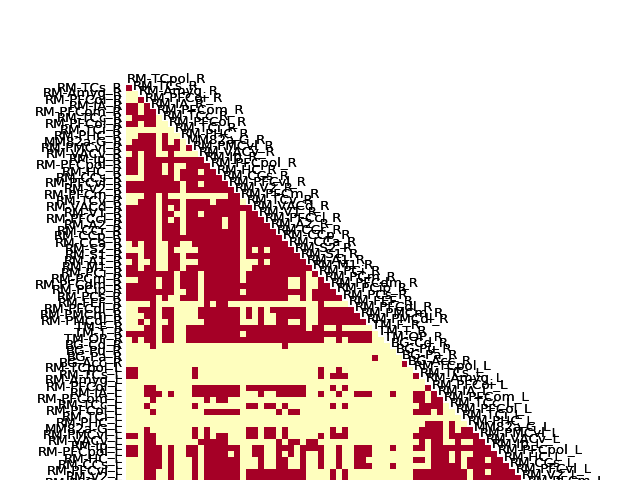

In [145]:
#Figure()
#plot_tri_matrix(sim.connectivity.weights,
#                cmap=pyplot.cm.RdYlBu_r, 
#                node_labels= sim.connectivity.region_labels,
#                size=[10., 10.],
#                color_anchor=(-1.0, 1.0));
#show()

In [17]:
R=np.array([[1, 2,8,9], [3, 4,6,8],[1,4,6,10]])
R

array([[ 1,  2,  8,  9],
       [ 3,  4,  6,  8],
       [ 1,  4,  6, 10]])

In [22]:
R[:,[0,1]]=0.
R

array([[ 0,  0,  8,  9],
       [ 0,  0,  6,  8],
       [ 0,  0,  6, 10]])